# CAP 6615 Neural Networks Programming Assignment 4 – CNN && RNN

### Keyuan Lu, Wenxuan Bao, Yiming Xu, Yufan Chen, Yue Bai

In [2]:
import numpy as np
import os
import random 
from datetime import datetime
from numpy import genfromtxt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import shutil
from tqdm import tqdm
from skimage.io import imread
import torchvision
from torchvision import transforms
import torch.utils.data as data
from torch.optim import Adam, SGD

## Step 1 - Design and build a dataset for CNN && RNN model

### Select S&P500 Dataset and Schiller P/E ratio. Make an overlay of the Schiller P/E from 1 Jan 1960 to 31 Dec 2020, onto the S&P500 for the same period.

In [3]:
# Read s&p500 price data and schiller pe data.
# Note that 'HistoricalPrices.csv' only includes data after 1978
# Therefore, we use two datasets for s&p500 price ('HistoricalPrices.csv' and 'HistoricalPrices_old.csv' ), 
# and will combine them later
price_new=pd.read_csv('HistoricalPrices.csv')
price_old=pd.read_csv('HistoricalPrices_old.csv')
pe=pd.read_csv('ie_data_PE_full.csv')

In [4]:
# Note that the P/E ratio is monthly data 
pe=pe.rename({'Date':'Date_PE'},axis=1)
pe

,Date_PE,PE_CAPE
0,1960.01,18.338285
1,1960.02,17.545275
2,1960.03,17.286021
3,1960.04,17.429767
4,1960.05,17.256171
...,...,...
727,2020.08,31.152309
728,2020.09,30.833593
729,2020.10,31.277783
730,2020.11,32.471647


In [5]:
# remove redundant variables
price_old = price_old.drop(['Volume', 'Adj Close' ], 1)
# transform Date to date timestamp
price_old['Date'] = pd.to_datetime(price_old['Date'])
price_old = price_old.loc[ (price_old['Date'] < '1978-01-03') &  (price_old['Date']  >= '1960-01-01' )]
price_old

,Date,Open,High,Low,Close
2511,1960-01-04,59.910000,59.910000,59.910000,59.910000
2512,1960-01-05,60.389999,60.389999,60.389999,60.389999
2513,1960-01-06,60.130001,60.130001,60.130001,60.130001
2514,1960-01-07,59.689999,59.689999,59.689999,59.689999
2515,1960-01-08,59.500000,59.500000,59.500000,59.500000
...,...,...,...,...,...
7016,1977-12-23,93.800003,94.989998,93.750000,94.690002
7017,1977-12-27,94.690002,95.209999,94.089996,94.690002
7018,1977-12-28,94.690002,95.199997,93.989998,94.750000
7019,1977-12-29,94.750000,95.430000,94.099998,94.940002


In [6]:
price_new['Date'] = pd.to_datetime(price_new['Date'])
#reverse the dataset
price_new = price_new.iloc[::-1].reset_index(drop = True)
#reset the column names
price_new. columns = ['Date', 'Open', 'High', 'Low', 'Close']
price_new

,Date,Open,High,Low,Close
0,1978-01-03,93.82,95.15,93.49,93.82
1,1978-01-04,93.52,94.10,93.16,93.52
2,1978-01-05,92.74,94.53,92.51,92.74
3,1978-01-06,91.62,92.66,91.05,91.62
4,1978-01-09,90.64,91.52,90.01,90.64
...,...,...,...,...,...
10839,2020-12-24,3694.03,3703.82,3689.32,3703.06
10840,2020-12-28,3723.03,3740.51,3723.03,3735.36
10841,2020-12-29,3750.01,3756.12,3723.31,3727.04
10842,2020-12-30,3736.19,3744.63,3730.21,3732.04


In [7]:
# combine two s&p500 datasets
# now the dataset includes all the s&p 500 price data from 1 Jan 1960 to 31 Dec 2020  
frames = [price_old, price_new]
price = pd.concat(frames).reset_index(drop = True)
price

,Date,Open,High,Low,Close
0,1960-01-04,59.910000,59.910000,59.910000,59.910000
1,1960-01-05,60.389999,60.389999,60.389999,60.389999
2,1960-01-06,60.130001,60.130001,60.130001,60.130001
3,1960-01-07,59.689999,59.689999,59.689999,59.689999
4,1960-01-08,59.500000,59.500000,59.500000,59.500000
...,...,...,...,...,...
15349,2020-12-24,3694.030000,3703.820000,3689.320000,3703.060000
15350,2020-12-28,3723.030000,3740.510000,3723.030000,3735.360000
15351,2020-12-29,3750.010000,3756.120000,3723.310000,3727.040000
15352,2020-12-30,3736.190000,3744.630000,3730.210000,3732.040000


In [8]:
price['Date_PE']=0.0
for i in range(price.shape[0]):
    month = price['Date'][i].month
    year = price['Date'][i].year
    price.loc[i, 'Date_PE']=year+month*0.01
# merge sp500 data with the Schiller P/E ratio based on Date.
data_full = pd.merge(price, pe, how='left', on='Date_PE')
data_full = data_full.drop(['Date_PE' ], 1)

In [8]:
# save the merged dataset
data_full.to_csv('Price_PE.csv')

In [9]:
data_full

,Date,Open,High,Low,Close,PE_CAPE
0,1960-01-04,59.910000,59.910000,59.910000,59.910000,18.338285
1,1960-01-05,60.389999,60.389999,60.389999,60.389999,18.338285
2,1960-01-06,60.130001,60.130001,60.130001,60.130001,18.338285
3,1960-01-07,59.689999,59.689999,59.689999,59.689999,18.338285
4,1960-01-08,59.500000,59.500000,59.500000,59.500000,18.338285
...,...,...,...,...,...,...
15349,2020-12-24,3694.030000,3703.820000,3689.320000,3703.060000,33.769789
15350,2020-12-28,3723.030000,3740.510000,3723.030000,3735.360000,33.769789
15351,2020-12-29,3750.010000,3756.120000,3723.310000,3727.040000,33.769789
15352,2020-12-30,3736.190000,3744.630000,3730.210000,3732.040000,33.769789


In [10]:
data_full['PE_CAPE']

0        18.338285
1        18.338285
2        18.338285
3        18.338285
4        18.338285
           ...    
15349    33.769789
15350    33.769789
15351    33.769789
15352    33.769789
15353    33.769789
Name: PE_CAPE, Length: 15354, dtype: float64

In [11]:
data_full['PE_CAPE'].values

array([18.33828499, 18.33828499, 18.33828499, ..., 33.76978942,
       33.76978942, 33.76978942])

### Note that the schiller pe ratio are monthly data. Here we modify the montly data to daily data. 

In [12]:
#modify the monthly schiller pe ratio to daily one
PE_monthly = data_full['PE_CAPE'].values
PE_daily = PE_monthly.copy()
price_tmp = data_full['Close'][0]
for i in range(1, len(PE_monthly)):
    if PE_monthly[i] == PE_monthly[i-1]:
        pe = PE_monthly[i]/price_tmp*data_full['Close'][i]
        PE_daily[i] = pe
        
    else:
        #new month
        price_tmp = data_full['Close'][i]
        PE_daily[i] = PE_monthly[i]
data_full['PE_CAPE'] = PE_daily        

In [13]:
data_full

,Date,Open,High,Low,Close,PE_CAPE
0,1960-01-04,59.910000,59.910000,59.910000,59.910000,18.338285
1,1960-01-05,60.389999,60.389999,60.389999,60.389999,18.485211
2,1960-01-06,60.130001,60.130001,60.130001,60.130001,18.405627
3,1960-01-07,59.689999,59.689999,59.689999,59.689999,18.270943
4,1960-01-08,59.500000,59.500000,59.500000,59.500000,18.212785
...,...,...,...,...,...,...
15349,2020-12-24,3694.030000,3703.820000,3689.320000,3703.060000,34.144236
15350,2020-12-28,3723.030000,3740.510000,3723.030000,3735.360000,34.442059
15351,2020-12-29,3750.010000,3756.120000,3723.310000,3727.040000,34.365344
15352,2020-12-30,3736.190000,3744.630000,3730.210000,3732.040000,34.411447


### Make an overlay of the Schiller P/E onto the S&P500 for the same period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


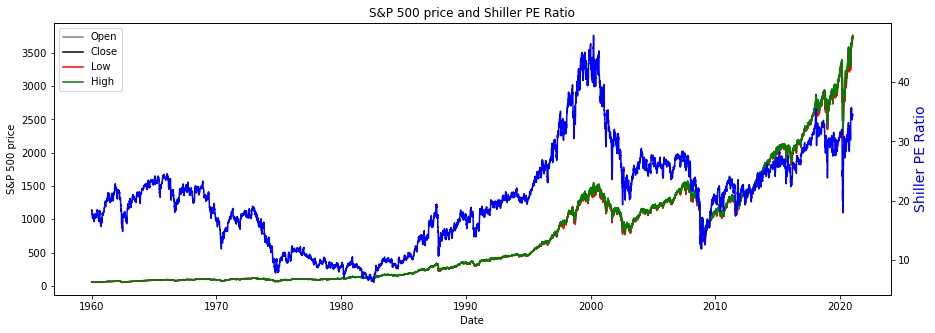

In [14]:
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, data_full.Open.values, color='grey', label='Open')
plt.plot(data_full.Date, data_full.Close.values, color='black', label='Close')
plt.plot(data_full.Date, data_full.Low.values, color='red', label='Low')
plt.plot(data_full.Date, data_full.High.values, color='green', label='High')
plt.title('S&P 500 price and Shiller PE Ratio')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
# twin object for two different y-axis on the sample plot
ax2=plt.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_full.Date, data_full.PE_CAPE.values,color="blue")
ax2.set_ylabel("Shiller PE Ratio", color="blue",fontsize=14)
plt.savefig('price_pe.eps')
plt.show()


### Here, we are only using ClOSE price and Cyclicily adjusted PE-ratio to train the model

In [11]:
dataset = data_full[ ['Close', 'PE_CAPE']].values
dataset

array([[  59.91      ,   18.33828499],
       [  60.389999  ,   18.33828499],
       [  60.130001  ,   18.33828499],
       ...,
       [3727.04      ,   33.76978942],
       [3732.04      ,   33.76978942],
       [3756.07      ,   33.76978942]])

In [16]:
# extract the timestamp data
date_data= data_full[ ['Date']].values

In [17]:
# Feature Scaling: min-max normalization of features
sc = MinMaxScaler(feature_range = (0, 1))
dataset_scaled = sc.fit_transform(dataset)
dataset_scaled

array([[0.00208161, 0.29057405],
       [0.0022112 , 0.29410392],
       [0.002141  , 0.29219192],
       ...,
       [0.99216225, 0.67562076],
       [0.99351219, 0.67672837],
       [1.        , 0.68205154]])

In [18]:
# number of timepoint and number of feature
n_rows, n_cols = dataset_scaled.shape
(n_rows, n_cols)

(15354, 2)

In [19]:
# general settings
# The number of expected features in the input x is 2
input_size = 2
# output_size = 4 as we want to predict the next one, two, three, and four trading data 
output_size = 4
# sequence length is 180
window_size = 180

In [20]:
# Creating a data structure with 180 timesteps and 4 output
X_full = []
y_full = []
date_full = []
for i in range( n_rows - window_size - output_size +1):
    X_full.append(dataset_scaled[i:i+window_size, ])
    y_full.append(dataset_scaled[i+window_size: i+ window_size + output_size, 0])
    date_full.append(date_data[i+window_size])
    
X_full, y_full, date_full = np.array(X_full), np.array(y_full), np.array(date_full)
y_full = np.reshape(y_full, (y_full.shape[0], 1, y_full.shape[1]))

In [21]:
X_full.shape

(15171, 180, 2)

In [22]:
y_full.shape

(15171, 1, 4)

## Step 2 - Develop and test/verify a correlation-based algorithm to correlate when the Schiller P/E ratio is very high (spikes upward significantly) and the S&P500 is also high (peaking or ready to peak)

In [23]:
##Compute correlation score S and add it to fourth column
dataset_scaled = np.append(dataset_scaled,np.zeros([len(dataset),1]),1)

In [25]:
dataset_scaled[0:10, 0]

array([0.00208161, 0.0022112 , 0.002141  , 0.00202221, 0.00197091,
       0.00177382, 0.00167662, 0.00158753, 0.00167393, 0.00166853])

In [24]:
#calcualte the pearson correlation for 180 trading days (same as the window size we use for the testing)
nsample = 180
for i in range(nsample-1 ,len(dataset_scaled)):
    # Pearson's r
    x = dataset_scaled[(i-nsample+1):(i+1), 0]
    y = dataset_scaled[(i-nsample+1):(i+1), 1]
    r = np.corrcoef(x, y)
    dataset_scaled[i][2] = r[0,1] 
dataset_scaled

array([[0.00208161, 0.29057405, 0.        ],
       [0.0022112 , 0.29410392, 0.        ],
       [0.002141  , 0.29219192, 0.        ],
       ...,
       [0.99216225, 0.67562076, 0.85676947],
       [0.99351219, 0.67672837, 0.86028787],
       [1.        , 0.68205154, 0.86429374]])

In [57]:
data_full.Date.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            15344, 15345, 15346, 15347, 15348, 15349, 15350, 15351, 15352,
            15353],
           dtype='int64', length=15354)

Text(0, 0.5, 'Pearson Correlation')

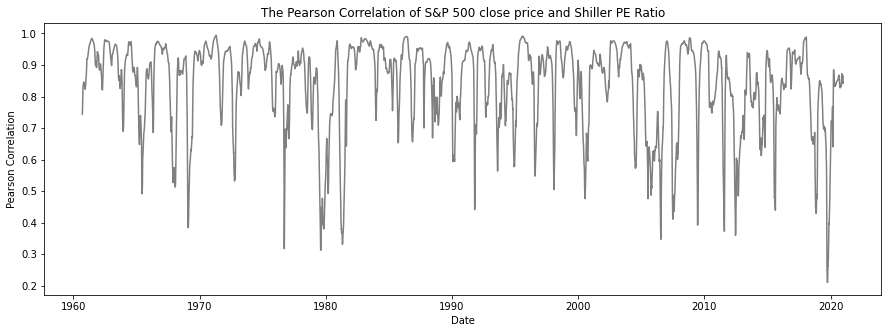

In [27]:
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date.loc[~data_full.Date.index.isin(list(range(nsample-1))) ],
         dataset_scaled[(nsample-1):, 2], color='grey', label='Close')
plt.title('The Pearson Correlation of S&P 500 close price and Shiller PE Ratio')
plt.xlabel('Date')
plt.ylabel('Pearson Correlation')
# plt.legend(loc='best')

In [28]:
dataset_scaled.shape

(15354, 3)

In [29]:
nsample

180

In [69]:
sellSignalIndex = []
prev = 0
for x in range(len(dataset_scaled)):
    #We add a shifting x-window, by shifting every plot nsample days to get more diverse plots
    # and given condition that the end price is the highest point and the price drop after that day
    if dataset_scaled[x][2] > 0.95 and x >= prev+nsample//3 and \
    dataset_scaled[x][0] == max(dataset_scaled[(x-nsample+1):(x+1), 0]) and \
    dataset_scaled[x][0] > dataset_scaled[x+1][0]:
        sellSignalIndex.append(x)
        prev = x

In [70]:
#Now, we have a candidate selling signal list
len(sellSignalIndex)

32

In [85]:
def drawPlotAndSave(data,index,folder):
    closedpriceInPrevDays = []
    xaxis = np.arange(0, nsample)
    for x in reversed(range(0, nsample)):
        closedpriceInPrevDays.append(data[index-x][0])
        
    # plotting
    name = "day%i" %index
    plt.axis('off')
    plt.plot(xaxis, closedpriceInPrevDays, color ="blue") 
    name = name + '.png'
    plt.savefig(folder + name, bbox_inches='tight', pad_inches=0)
    plt.clf()
    

In [86]:
#Create the CandaidateTrain folder manually, then run this to create all possible selling signals
import os
import shutil

folder = 'CandidateTrainSell/'
if os.path.exists(folder ):
    shutil.rmtree(folder )
os.makedirs(folder )

for x in sellSignalIndex:
    drawPlotAndSave(dataset_scaled,x,folder)

<Figure size 432x288 with 0 Axes>

In [88]:
# not sell 
holdSignalIndex = []
prev = 0
for x in range(len(dataset_scaled)):
    if dataset_scaled[x][2] <0.5  and x >= prev+nsample//3:
        holdSignalIndex.append(x)
        prev = x
#Now, we have a candidate not selling signal list
len(holdSignalIndex)

24

In [93]:
#Create the CandaidateTrain folder manually, then run this to create all possible hold signals
folder = 'CandidateTrainHold/'
if os.path.exists(folder ):
    shutil.rmtree(folder )
os.makedirs(folder )

for x in holdSignalIndex:
    drawPlotAndSave(dataset_scaled,x,folder)

<Figure size 432x288 with 0 Axes>

### Manually picking CandidateTrain sample, which almost fitting the required ABCD pattern from assignment for label=1 sample

In [94]:
# loading training images
train_img = []
for img_name in tqdm(sellSignalIndex):
    # defining the image path
    image_path = 'CandidateTrainSell/day' + str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)
train_y = np.repeat(1, len(sellSignalIndex))
for img_name in tqdm(holdSignalIndex):
    # defining the image path
    image_path = 'CandidateTrainHold/day' + str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)
np.append(train_y,np.repeat(0, len(holdSignalIndex))  )  
    
# converting the list to numpy array
train_x = np.array(train_img)
# defining the target

train_x.shape

100%|██████████| 24/24 [00:00<00:00, 267.67it/s]


(56, 217, 334)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7faed599c430>)

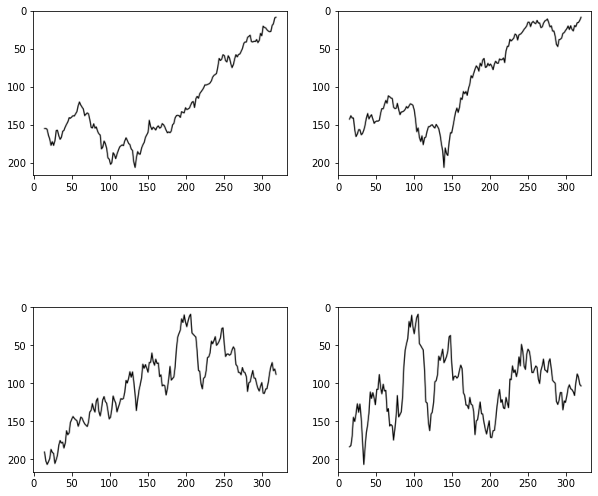

In [95]:
# visualizing images 
#first two sell 
#last two hold
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i], cmap='gray')
plt.subplot(222), plt.imshow(train_x[i+1], cmap='gray')
plt.subplot(223), plt.imshow(train_x[i+40], cmap='gray')
plt.subplot(224), plt.imshow(train_x[i+41], cmap='gray')

## Step 3 - Develop CNN and train it with picked Sell and Hold datasets

In [265]:

EPOCHS = 6
TRAIN_BATCH_SIZE = 4
TEST_BATCH_SIZE = 1
LEARNING_RATE = 0.001
TRAIN_DATA_PATH = "./CNN_Train/"
TEST_DATA_PATH = "./CNN_Test/"
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])



In [266]:
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = data.DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True,  num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=4) 


In [267]:
test_data

Dataset ImageFolder
    Number of datapoints: 8
    Root location: ./CNN_Test/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [268]:
class CNN(nn.Module):   
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 3, kernel_size= 64, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            nn.Conv2d(3, 3, kernel_size= 32, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            nn.Conv2d(3, 3, kernel_size= 16, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(1323, 2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [269]:
print("Number of train samples: ", len(train_data))
print("Number of test samples: ", len(test_data))
print("Detected Classes are: ", train_data.class_to_idx) # classes are detected by folder structure

model = CNN()    
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
loss_func = nn.CrossEntropyLoss()    

        # Training and Testing
for epoch in range(EPOCHS):        
    for step, (x, y) in enumerate(train_data_loader):
        b_x = Variable(x)   # batch x (image)
        b_y = Variable(y)   # batch y (target)
        output = model(b_x)  
        loss = loss_func(output, b_y)   
        optimizer.zero_grad()           
        loss.backward()                 
        optimizer.step()
        if step % 5 == 0:
            countHold = 0
            countSell = 0
            for S, (x, y) in enumerate(test_data_loader):
                test_x = Variable(x)
                test_y = Variable(y)
                test_output = model(test_x)
                if test_y == 1 and torch.argmax(test_output) == test_y:
                    countSell = countSell + 1
                if test_y == 0 and torch.argmax(test_output) == test_y:
                    countHold = countHold + 1
            accuracyhold = countHold/4
            accuracysell = countSell/4
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| Hold/Sell accuracy: %.2f/%.2f' %(accuracyhold,accuracysell))

Number of train samples:  48
Number of test samples:  8
Detected Classes are:  {'CandidateTrainHold': 0, 'CandidateTrainSell': 1}
Epoch:  0 | train loss: 0.8519 | Hold/Sell accuracy: 0.50/0.75
Epoch:  0 | train loss: 0.9752 | Hold/Sell accuracy: 0.75/0.75
Epoch:  0 | train loss: 0.6379 | Hold/Sell accuracy: 0.00/1.00
Epoch:  1 | train loss: 0.5715 | Hold/Sell accuracy: 0.00/1.00
Epoch:  1 | train loss: 0.8439 | Hold/Sell accuracy: 0.25/1.00
Epoch:  1 | train loss: 0.1543 | Hold/Sell accuracy: 0.25/0.75
Epoch:  2 | train loss: 0.1653 | Hold/Sell accuracy: 0.25/0.75
Epoch:  2 | train loss: 0.3671 | Hold/Sell accuracy: 0.25/0.75
Epoch:  2 | train loss: 0.3018 | Hold/Sell accuracy: 0.50/0.75
Epoch:  3 | train loss: 0.3224 | Hold/Sell accuracy: 0.50/1.00
Epoch:  3 | train loss: 0.1170 | Hold/Sell accuracy: 0.25/1.00
Epoch:  3 | train loss: 0.2711 | Hold/Sell accuracy: 0.00/1.00
Epoch:  4 | train loss: 0.2450 | Hold/Sell accuracy: 0.25/1.00
Epoch:  4 | train loss: 0.1320 | Hold/Sell accuracy

## Step x - Profit simulation 

In [56]:
dataset[0]

array([59.91      , 18.33828499])

In [57]:
def buy(buypoint, currentMoney):
    return currentMoney/dataset[buypoint][0], dataset[buypoint][0]
#Buy 1 million stocks at the frist day
currentSPStocks, initialPrice = buy(0,1000000)
currentSPStocks

16691.70422300117

In [58]:
def sell(sellPoint, sellAmount, currentSPStocks):
    return (currentSPStocks - sellAmount),  (dataset[sellPoint][0] - initialPrice) 


In [59]:
totalProfit = 0
currentSPStocks, profit = sell(1000,100,currentSPStocks)

In [60]:
totalProfit = totalProfit+profit

In [61]:
totalProfit

14.060001

In [62]:
currentSPStocks

16591.70422300117